### Imports and Load Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord

# this will require installing gala, see here: http://gala.adrian.pw/en/latest/index.html
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
from gala.dynamics.nbody import DirectNBody
import gala.integrate as gi
from gala.dynamics import mockstream as ms # this is for generating stream models

import galstreams

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
mwsts = galstreams.MWStreams(verbose=False, implement_Off=False)

Initializing galstreams library from master_log... 


In [3]:
# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

## Read in simulation data

In [4]:
from helpers.SimulationAnalysis import SimulationAnalysis, iterTrees
from helpers.SimulationAnalysis import readHlist

In [5]:
#Path to simulation data
h = 0.7
path_to_data = ''

#Halo properties to load; see Section 2.4 of https://arxiv.org/abs/2008.08591 for info on Rockstar fields 
fields = ['scale','id', 'upid', 'pid', 'mvir', 'mpeak', 'rvir', 'RVmax', 'rs', 'vmax', 'vpeak', 'x', 'y', 'z', 'vx', 'vy', 'vz',
          'M200c', 'depth_first_id','scale_of_last_MM']

#Load z = 0 halo list for Halo416_16K
halos_z0 = readHlist(path_to_data+'hlist_1.00000.list',fields=fields)
MW_analog = halos_z0[np.argmax(halos_z0['mvir'])]

subhalos_z0 = halos_z0[halos_z0['upid']==MW_analog['id']]
LMC_analog = subhalos_z0[np.argmax(subhalos_z0['mvir'])]


#Reading in data from dm particles
t = Table.read('snapshot_now.fits')

# ind_lmc = subhalos_z0['pid']==LMC_analog['id']
ind_lmc = np.argmax(subhalos_z0['mvir'])

In [7]:
r_peri = dict(LMS_1=10.8, Gjoll=8.5, Leiptr=12.3, Hrid=1.1, Pal5=6.9, Orphan=15.6, 
             Gaia_1=8.2, Fimbulthul=2.4, Ylgr=11.5, Fjorm=9.1, Kshir=13.4, Cetus=14.7,
             Svol=5.9, Gunnthra=4.2, Slidr=8.7, M92=3.0, NGC_6397=3.4, NGC_3201=8.5,
             Ophiuchus=3.9, Atlas=11.7, C_7=3.5, C_3=5.7, Palca=10.8, Sylgr=8.7,
             Gaia_6=6.0, Gaia_9=8.7, Gaia_10=4.3, Gaia_12=18.5, Indus=12.6, Jhelum=8.7,
             Phoenix=11.7, NGC5466=4.8, M5=3.4, C_20=20.8, NGC7089=2.9, C_19=9.3,
             Elqui=12.1, Chenab=22.0, AliqaUma=11.6, Phlegethon=5.5, GD_1=14.1)


In [8]:
r_apo = dict(LMS_1=20.6, Gjoll=27.4, Leiptr=45.1, Hrid=22.0, Pal5=15.8, Orphan=41.2, 
             Gaia_1=67.6, Fimbulthul=7.2, Ylgr=20.7, Fjorm=29.1, Kshir=16.0, Cetus=35.9,
             Svol=10.0, Gunnthra=7.2, Slidr=32.3, M92=10.7, NGC_6397=6.4, NGC_3201=30.5,
             Ophiuchus=14.2, Atlas=32.4, C_7=21.0, C_3=10.0, Palca=16.5, Sylgr=24.6,
             Gaia_6=9.5, Gaia_9=20.8, Gaia_10=37.7, Gaia_12=194.3, Indus=18.9, Jhelum=24.5,
             Phoenix=18.1, NGC5466=33.7, M5=24.8, C_20=58.5, NGC7089=14.7, C_19=21.6,
             Elqui=54.0, Chenab=81.0, AliqaUma=31.9, Phlegethon=22.1, GD_1=23.0)


## Integrate orbits

The internal structure of dark matter halos is well described by a NFW profile. For more details, see the wiki page: https://en.wikipedia.org/wiki/Navarro%E2%80%93Frenk%E2%80%93White_profile
(the original article is here: https://ui.adsabs.harvard.edu/abs/1997ApJ...490..493N/abstract)

We will be using the implementation in gala: http://gala.adrian.pw/en/latest/api/gala.potential.potential.NFWPotential.html#gala.potential.potential.NFWPotential

Here is a gala tutorial for calculating an orbit in a dark matter halo (that is, assuming an NFW gravitational potential): http://gala.adrian.pw/en/latest/tutorials/integrate-potential-example.html

In [6]:
# in our case, we'll define the gravitational potential with the mass and scale radius of the MW_analog halo
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, r_s=MW_analog['rs']/h*u.kpc, units=galactic))


### Stream models

We will create stream models using the "particle spray" method. For a description of the basic method, see the first part of section 3 in Bonaca et al. 2014 paper: https://ui.adsabs.harvard.edu/abs/2014ApJ...795...94B/abstract. Gala has an implementation of a more general method, and describes how to use it here: http://gala.adrian.pw/en/latest/dynamics/mockstreams.html

I'll give an example of Gaia-12 since it has the largest apocenter.

Same as before, we'll start by takin an anchor point for a stream orbit from Table 1 in Malhan et al. paper: https://ui.adsabs.harvard.edu/abs/2022ApJ...926..107M/abstract only this time, we'll assume the anchor point is where the stream progenitor would be. In case of Gaia-12, the progenitor has likely disrupted, so our model will not be completely realistic, but it will have a similar extent to the real stream, which is what matters more for estimating the effect of subhalos on it.

In [9]:
name = 'Slidr-I21'
#Information for Slidr coming from Malhan
c = coord.SkyCoord(ra=160.05*u.deg, dec=10.22*u.deg, distance=2.99*u.kpc, pm_ra_cosdec=-24.6*u.mas/u.yr,
                  pm_dec=-6.65*u.mas/u.yr, radial_velocity=-87.98*u.km/u.s, frame='icrs')
w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)


In [10]:
# setup how stars get released from the progenitor
state = np.random.RandomState(seed=291)
df = ms.FardalStreamDF(random_state=state) #distribution function for stream disruption og GlobClust

prog_mass = 1e4*u.Msun
gen = ms.MockStreamGenerator(df, ham)

In [23]:
dt = -1*u.Myr # negative time step means that we are giving the present-day position of the progenitor
#the nstep will change according to stream
Nstep = 370 # I started with 2000, but decreased it until the length of the model matched the detected stream
nrelease = 2 # release stars every second timestep
stream_, prog = gen.run(w0, prog_mass, dt=dt, n_steps=Nstep, release_every=nrelease)

In [24]:
# transform stream model to sky coordinates
stream = stream_.to_coord_frame(coord.ICRS())

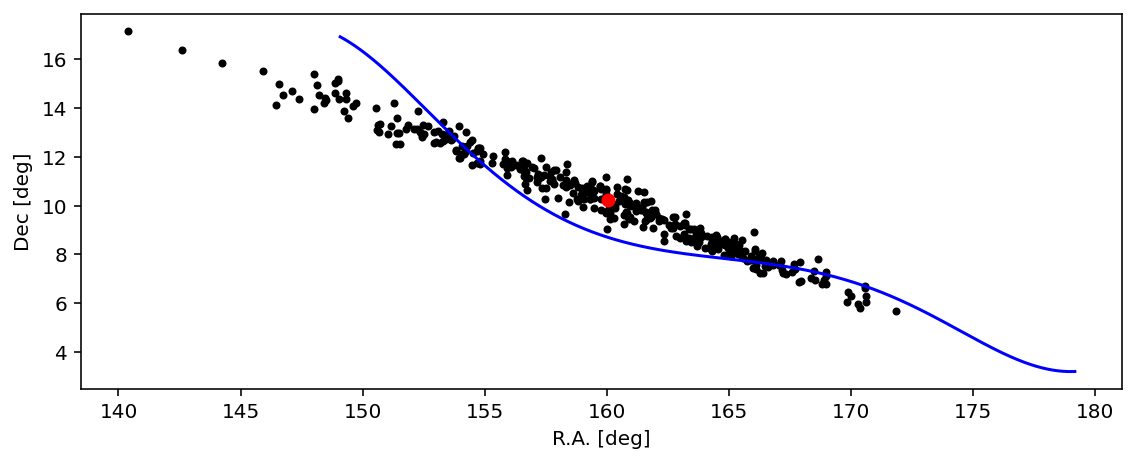

In [25]:
plt.figure(figsize=(8,6))
plt.plot(stream.ra, stream.dec, 'k.')
plt.plot(c.ra.wrap_at(180*u.deg), c.dec, 'ro')
plt.plot(mwsts[name].track.ra.wrap_at(180*u.deg), mwsts[name].track.dec, 'b-')

plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
plt.gca().set_aspect('equal')
plt.tight_layout()

### LMC perturbation

#### halo rotation

In [27]:
ind_massive = (subhalos_z0['mvir'] > 10**7)
len(subhalos_z0['mvir'][ind_massive])

1072

In [28]:
ts = Table(subhalos_z0[ind_massive])
for comp in ['x', 'y', 'z']:
    ts[comp] = ((ts[comp] - MW_analog[comp])*u.Mpc/h).to(u.kpc)
for comp in ['vx', 'vy', 'vz']:
    ts[comp] = (ts[comp] - MW_analog[comp])*u.km/u.s

In [29]:
c_sh = coord.Galactocentric(x=ts['x'], y=ts['y'], z=ts['z'], 
                            v_x=ts['vx'], v_y=ts['vy'], v_z=ts['vz'])
ceq_sh = c_sh.transform_to(coord.ICRS())

In [30]:
ceq_lmc = coord.ICRS(ra=78.76*u.deg, dec=-69.19*u.deg, distance=(10**(0.2*18.50+1)*u.pc).to(u.kpc), 
                     radial_velocity=262.2*u.km/u.s, pm_ra_cosdec=1.91*u.mas/u.yr, pm_dec=0.229*u.mas/u.yr)
c_lmc = ceq_lmc.transform_to(coord.Galactocentric())

In [31]:
ind_lmc = np.argmax(subhalos_z0['mvir'])
ceq_sh[ind_lmc]

<ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
    (112.81196526, 17.46739192, 92.87612384)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0.52617911, -0.53215685, 353.97114326)>

In [32]:
ceq_lmc

<ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
    (78.76, -69.19, 50.11872336)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (1.91, 0.229, 262.2)>

This is following: https://math.stackexchange.com/questions/2754627/rotation-matrices-between-two-points-on-a-sphere

In [33]:
vsim = np.array([c_sh.x.value[ind_lmc], c_sh.y.value[ind_lmc], c_sh.z.value[ind_lmc]])
vsim = vsim / np.linalg.norm(vsim)

vtrue = np.array([c_lmc.x.value, c_lmc.y.value, c_lmc.z.value])
vtrue = vtrue / np.linalg.norm(vtrue)

In [34]:
np.shape(vsim), vtrue

((3,), array([-0.01956117, -0.82754257, -0.56106208]))

In [35]:
vpole = np.cross(vsim, vtrue)
vpole = vpole / np.linalg.norm(vpole)

In [36]:
theta = np.arccos(np.dot(vsim,vtrue)/(np.linalg.norm(vsim)*np.linalg.norm(vtrue)))

with the rotation matrix given by: https://en.wikipedia.org/wiki/Rotation_matrix#Rotation_matrix_from_axis_and_angle

In [37]:
R = np.array([[np.cos(theta) + vpole[0]**2*(1-np.cos(theta)),
              vpole[0]*vpole[1]*(1-np.cos(theta)) - vpole[2]*np.sin(theta),
              vpole[0]*vpole[2]*(1-np.cos(theta)) + vpole[1]*np.sin(theta)],
             [vpole[1]*vpole[0]*(1-np.cos(theta)) + vpole[2]*np.sin(theta),
              np.cos(theta) + vpole[1]**2*(1-np.cos(theta)),
              vpole[1]*vpole[2]*(1-np.cos(theta)) - vpole[0]*np.sin(theta)],
             [vpole[2]*vpole[0]*(1-np.cos(theta)) - vpole[1]*np.sin(theta),
              vpole[2]*vpole[1]*(1-np.cos(theta)) + vpole[0]*np.sin(theta),
              np.cos(theta) + vpole[2]**2*(1-np.cos(theta))]])

In [38]:
vtest = np.matmul(R,vsim)

In [39]:
vtest

array([-0.01956117, -0.8275426 , -0.5610621 ])

In [40]:
vtrue

array([-0.01956117, -0.82754257, -0.56106208])

#### rotated table

In [41]:
trot = Table(subhalos_z0[ind_massive])
N = len(trot)
trot['x'] = np.zeros(N)#*u.kpc
trot['y'] = np.zeros(N)#*u.kpc
trot['z'] = np.zeros(N)#*u.kpc

trot['vx'] = np.zeros(N)#*u.km/u.s
trot['vy'] = np.zeros(N)#*u.km/u.s
trot['vz'] = np.zeros(N)#*u.km/u.s

for i in range(N):
    # positions
    temp_vec = np.array([ts['x'][i], ts['y'][i], ts['z'][i]])
    rot_vec = np.matmul(R, temp_vec)
    
    trot['x'][i] = rot_vec[0]#*u.kpc
    trot['y'][i] = rot_vec[1]#*u.kpc
    trot['z'][i] = rot_vec[2]#*u.kpc
    
    # velocities
    temp_vec = np.array([ts['vx'][i], ts['vy'][i], ts['vz'][i]])
    rot_vec = np.matmul(R, temp_vec)
    
    trot['vx'][i] = rot_vec[0]#*u.kpc
    trot['vy'][i] = rot_vec[1]#*u.kpc
    trot['vz'][i] = rot_vec[2]#*u.kpc

In [42]:
trot

scale,id,upid,pid,mvir,mpeak,rvir,RVmax,rs,vmax,vpeak,x,y,z,vx,vy,vz,M200c,depth_first_id,scale_of_last_MM
float32,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float32,int64,float32
1.0,72459389,72506199,72506199,120700000000.0,205000000000.0,101.534,19.3006,4.672,103.07,120.28,-1.9599346441515664,-82.91581878201421,-56.21574545318059,41.79535938438639,-309.3911548468411,4.169373074233404,107950000000.0,5533817,0.86916
1.0,72450712,72506199,72459389,57970000000.0,80900000000.0,79.506,12.1709,2.452,86.01,92.67,19.90469941445416,-86.73026998775049,-78.63497132388338,-218.04374828506053,-94.9571174646542,31.981945046736662,53978000000.0,8426009,0.3844
1.0,72519929,72506199,72506199,25320000000.0,25740000000.0,60.324,7.65685,3.405,58.68,60.05,40.51952434373715,220.41956840799867,168.72461548991257,2.53517484879427,-218.6835759170639,-112.24519557916568,22614000000.0,10033184,0.14041
1.0,72449874,72506199,72450712,10910000000.0,14480000000.0,45.568,5.64519,1.29,50.03,57.88,112.99428921774361,-89.69790057276299,-101.88445240628293,34.17528670968785,-189.70177711924015,-81.70782595097783,10684000000.0,11728161,0.21659
1.0,72469252,72506199,72459389,3997000000.0,9972000000.0,32.601,3.98983,0.553,42.49,51.68,-80.7158924016363,-43.63220988532212,-41.03613330734938,1.6404752924872206,-42.74149479022687,-224.61790612318,3979800000.0,13690590,0.32569
1.0,72499132,72506199,72506199,3787000000.0,7354000000.0,32.019,2.20292,0.555,41.06,51.66,208.41599574083165,-192.56975460710208,81.38811529021346,-48.65259895928822,39.901440275846504,-43.05374990567632,3671000000.0,13865261,0.18587
1.0,72449455,72506199,72450712,2479000000.0,19250000000.0,27.803,1.72488,0.329,39.39,63.47,89.26177293486964,-39.37037472952912,-63.19375026013911,-103.00144637242184,15.04213988696808,22.067638779305643,2395500000.0,14836877,0.08874
1.0,72524002,72506199,72506199,1988000000.0,2470000000.0,25.831,2.30569,0.562,31.44,37.15,-119.7141498527599,57.78660245857486,114.26419956270568,19.183535746168204,165.47257890433747,68.89573851079723,1945800000.0,15369227,0.08013
1.0,72524313,72506199,72506199,1577000000.0,4961000000.0,23.912,1.98646,0.287,32.24,40.84,-138.1078821850083,11.6819497910626,160.89746197857568,-16.5269381879806,-38.723077733847646,-4.28399251539551,1495600000.0,15790527,0.0568


In [43]:
crot = coord.Galactocentric(x=trot['x']*u.kpc, y=trot['y']*u.kpc, z=trot['z']*u.kpc, 
                            v_x=trot['vx']*u.km/u.s, v_y=trot['vy']*u.km/u.s, v_z=trot['vz']*u.km/u.s)

In [ ]:
#This is the radius from the center at which the maximum velocity occurs
#trot['rs'] = (trot['RVmax'])/2.163

#### add Subhalo 688 perturber to stream generation

In [ ]:
ts['rs'][688], ts['mvir'][688] #HERE I WOULD ADD THE AUBHLO RATHER THAN THE LMC

In [ ]:
# this defines the additional contribution to the gravitational potential from the subhalo
# here you should use the better estimate of the scale radius using vmax
sh_pot = gp.NFWPotential(m=ts['mvir'][688]*u.Msun/h, r_s=((ts['RVmax'])/2.163)[688]*u.kpc/h, units=galactic) #Use rs = RVmax/2.163 




In [ ]:
# present-day position of the subhalo
w0_sh = gd.PhaseSpacePosition(crot[688].cartesian)

In [ ]:
# here we define an Nbody object which contains the present day position of the subhalo and its potential
# in this example it only has the single object, but in yours it will have 5 simultaneously
# so you'll need w0 to have positions of all subhalos you want to include
# and include a list of their individual potentials as the second argument
# more info: http://gala.adrian.pw/en/latest/dynamics/nbody.html
nbody = DirectNBody(w0_sh, [sh_pot], external_potential=ham.potential) #w0 is position and sh is gravitational potential of the same thing, in my case i use a subhalo



In [ ]:
# this is the same as before
# setup how stars get released from the progenitor
state = np.random.RandomState(seed=291)
df = ms.FardalStreamDF(random_state=state)

prog_mass = 1e4*u.Msun
gen = ms.MockStreamGenerator(df, ham)

In [ ]:
dt = -1*u.Myr # negative time step means that we are giving the present-day position of the progenitor
Nstep = 300 # I started with 2000, but decreased it until the length of the model matched the detected stream
nrelease = 2 # release stars every second timestep

# here we include the nbody in the stream generation
stream_sh_, prog = gen.run(w0, prog_mass, dt=dt, n_steps=Nstep, release_every=nrelease, nbody=nbody)

In [ ]:
# transform stream model to sky coordinates
stream_sh = stream_sh_.to_coord_frame(coord.ICRS())

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(stream.ra, stream.dec, 'k.')
plt.plot(stream_sh.ra, stream_sh.dec, 'r.')
# plt.plot(c.ra.wrap_at(180*u.deg), c.dec, 'ro')
plt.plot(mwsts[name].track.ra.wrap_at(180*u.deg), mwsts[name].track.dec, 'b-')

plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
plt.gca().set_aspect('equal')
plt.tight_layout()

It looks like the LMC analog shifts the stream a little bit. Let's see what the impact those close encounters have on Gaia-1!

In [ ]:
plt.figure()
plt.hist(subhalos_z0[ind_massive]['mvir'], bins=np.logspace(6,12,70), color='blue', label='Subhalos'); 
#plt.hist(r_peri.values(),bins=np.linspace(-1,200,70), color='red', histtype='step', label='Streams Pericenter')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Subhalo Mass')
plt.ylabel('Total Number of Subhalos')
plt.xlim(10**7, 10**12)
plt.title('Distribution of Mass in Subhalos')

In [ ]:
LMC_analog['mvir']